In [58]:
import nidaqmx
import nidaqmx.stream_readers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import csv
from scipy import stats

In [59]:
# Plotting Functions

# Plot only voltage data - Galvo Waveform
def plot_galvo(title, xlabel, ylabel, data):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data) 

# Plot scatterplot - X and Y data
def plot_xy_scatter(title, xlabel, ylabel, xdata, ydata):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(xdata, ydata)

# Plot Line graph
def plot_line(xdata, y1, freq=None, title=None, xlabel="Time [s]", ylabel="Voltage [V]", ylabel1=None, ylabel2=None, ylabel3=None, y2=None, y3=None, markers=None):
    fig, ax = plt.subplots()
    
    if title == None: # Default title
        if freq == None:
            ax.set_title("Galvo scanner response to command wave")
        else:
            ax.set_title("Galvo scanner response to command wave (" + str(freq) + "Hz)")
    else:
        ax.set_title(title)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    if markers == None: # If markers are needed (for start and stop voltages - for y1 data only)
        if ylabel1 == None:
            ax.plot(xdata, y1)
        else:
            ax.plot(xdata, y1, label=ylabel1)
    else:
        if ylabel1 == None:
            ax.plot(xdata, y1, marker='o', markevery=markers)
        else:
            ax.plot(xdata, y1, label=ylabel1, marker='o', markevery=markers)
    
    if y2 is not None: # Plot multiple sets of data
        ax.plot(xdata, y2, label=ylabel2)
        if y3 is not None:
            ax.plot(xdata, y3, label=ylabel3)
        ax.legend()
    ax.plot()

# CMD and POS from 0 to 0.5 seconds
def plot_cmd_pos_zoom(t, cmd, pos):
    fig, ax = plt.subplots()
    ax.set_title("Galvo scanner response to command wave zoomed in")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.plot(t[:2500], cmd[:2500], label="cmd")
    ax.plot(t[:2500], pos[:2500], label="pos")
    ax.legend()

In [60]:
# Write X and Y data to csv
def write_to_csv(name, x, y):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)
    for w in range(len(cmd)):
        writer.writerow([x[w], y[w]])
    file.close()

# Write X, Y1, and Y2 data to csv
def write_to_csv2(name, t, cmd, pos):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)

    for w in range(len(cmd)):
        writer.writerow([t[w], cmd[w], pos[w]])
    file.close()

def open_csv(filename):
    file = open(filename + ".csv")
    csvreader = csv.reader(file)
    t_list = []
    cmd_list = []
    pos_list = []
    for row in csvreader:
        if row:
            t_list.append(float(row[0]))
            cmd_list.append(float(row[1]))
            pos_list.append(float(row[2]))
    file.close()
    return t_list, cmd_list, pos_list

In [61]:
# Galvo Parameters

zoom = 1
undershoot = 50
pixelsPerLine = 256 #100
linesPerFrame = 256 #100
X_RETRACE_LEN = 128

In [62]:
# Generating Waveform - from OpenScan

def SplineInterpolate(n, yFirst, yLast, slopeFirst, slopeLast):
    m = float(n)
    mm = float(m * m)
    mmm = float(m * m *m)
    c = []
    c.append(slopeFirst / mm + 2.0 * yFirst / mmm + slopeLast / mm - 2.0 * yLast / mmm)
    c.append(3.0 * yLast / mm - slopeLast / m - 2.0 * slopeFirst / m - 3.0 * yFirst / mm)
    c.append(slopeFirst)
    c.append(yFirst)
    
    result = []
    n = int(n)
    for i in range(n):
        result.append(c[0] * i*i*i + c[1] * i*i + c[2] * i + c[3])
    return result

def GenerateXWaveform(scanLen, retraceLen, undershootLen, scanStart, scanEnd):
    waveform = []
    scanAmp = scanEnd - scanStart
    step = scanAmp/scanLen
    linearLen = undershootLen + scanLen
    undershootStart = scanStart - undershootLen * step
    
    for i in range(linearLen):
        val = undershootStart + step * i
        waveform.append(val)
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, undershootStart, step, step)
        completeWaveform = waveform + splineWaveform
    return completeWaveform

def GenerateYWaveform(linesPerFrame, retraceLen, xLength, scanStart, scanEnd):
    scanAmp = scanEnd - scanStart
    step = scanAmp/linesPerFrame
    waveform = np.zeros(linesPerFrame * xLength)
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
    for j in range(linesPerFrame):
        for i in range(xLength):
            waveform[i + j * xLength] = scanStart + step * j
            nextIndex = i + j * xLength
            if j >= (linesPerFrame - 1) and i >= (xLength - X_RETRACE_LEN):
                break
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
        for i in range(X_RETRACE_LEN):
            waveform[nextIndex + i] = splineWaveform[i]
    return waveform

def GenerateGalvoFrame(width, height, resolution, zoom, undershoot, xOffset, yOffset, galvoX, galvoY):
    xStart = (-0.5 * resolution + xOffset) / (zoom * resolution)
    yStart = (-0.5 * resolution + yOffset) / (zoom * resolution)
    xEnd = xStart + pixelsPerLine / (zoom * resolution)
    yEnd = yStart + linesPerFrame / (zoom * resolution)
    
    offsetXinDegree = galvoX / 3.0
    offsetYinDegree = galvoY / 3.0
    xLength = undershoot + pixelsPerLine + X_RETRACE_LEN
    yLength = linesPerFrame
    
    xWaveformFrame = GenerateXWaveform(pixelsPerLine, X_RETRACE_LEN, undershoot, xStart, xEnd)
    yWaveformFrame = GenerateYWaveform(linesPerFrame, X_RETRACE_LEN, xLength, yStart, yEnd)
    waveformFrame = np.zeros(2 * xLength * yLength)
    fullXWaveformFrame = []
    for j in range(yLength):
        for i in range(xLength):
            waveformFrame[i + j * xLength] = (xWaveformFrame[i] + offsetXinDegree)
            waveformFrame[i + j * xLength + yLength * xLength] = (yWaveformFrame[i + j * xLength] + offsetYinDegree)
    return waveformFrame
                

In [63]:
# zoom, undershoot = default
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)

Number of samples: 222208


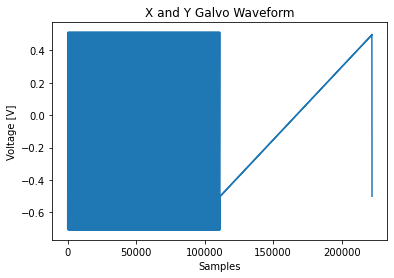

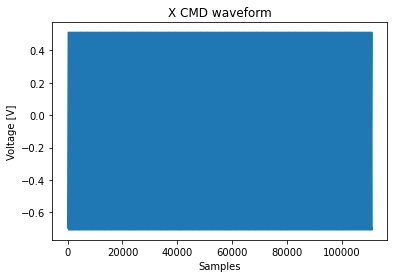

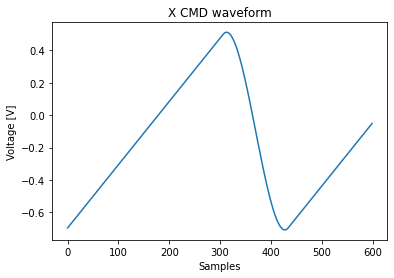

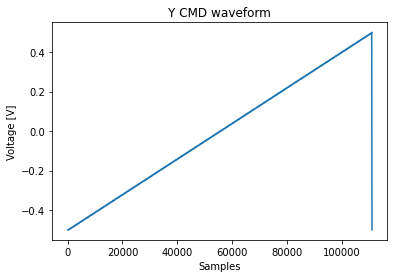

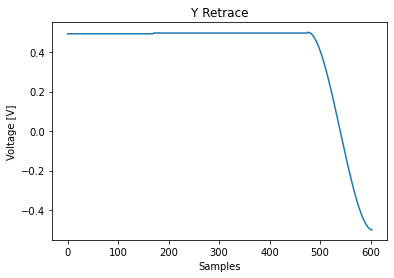

In [64]:
# X and Y frame
frameLength = len(frame)
print("Number of samples: " + str(frameLength))
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)

# X frame
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])

# Y frame
yFrame = frame[int(frameLength / 2):]
plot_galvo("Y CMD waveform", "Samples", "Voltage [V]", yFrame)
plot_galvo("Y Retrace", "Samples", "Voltage [V]", yFrame[110500:])

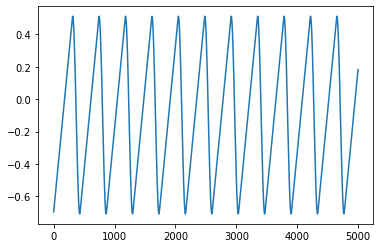

In [102]:
xFrame_waveform = xFrame[:5000] # Get first 5000 samples to write to scanner
plt.plot(xFrame_waveform)

In [65]:
# Scanner setting parameters

device = "Dev1"
aichan = "ai0"
aochan = "ao0"

In [66]:
# Writing to Scanner

def get_pos_waveform(waveform_segments):
    pos_waveform = np.concatenate(waveform_segments)
    return pos_waveform

def write_voltage_waveform(samp_rate, x_waveform):
    pos_waveform_segments = []  # list of 1D arrays
    
    # set parameters
    total_samples = 5000
    duration = total_samples / samp_rate
    t = np.linspace(0, duration, total_samples, endpoint=False)
    read_size = 1000  # samples
    cmd_waveform = x_waveform
    
    # Write to channels
    FINITE = nidaqmx.constants.AcquisitionType.FINITE
    with nidaqmx.Task() as intask:
        intask.ai_channels.add_ai_voltage_chan(f"{device}/{aichan}")
        intask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)

        reader = nidaqmx.stream_readers.AnalogSingleChannelReader(intask.in_stream)
        def input_callback(task, event_type, n_samples, data):
            buffer = np.empty(n_samples)
            n_read = reader.read_many_sample(buffer, n_samples)
            pos_waveform_segments.append(buffer[:n_read])
            return 0
        intask.register_every_n_samples_acquired_into_buffer_event(read_size, input_callback)

        intask.triggers.start_trigger.cfg_dig_edge_start_trig(f"/{device}/ao/StartTrigger")
        intask.start()

        with nidaqmx.Task() as outtask:
            outtask.ao_channels.add_ao_voltage_chan(f"{device}/{aochan}")
            outtask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)
            outtask.write(cmd_waveform, auto_start=True)
            outtask.wait_until_done()

        intask.wait_until_done()
        
    pos_waveform = get_pos_waveform(pos_waveform_segments)
    
    return t, cmd_waveform, pos_waveform

In [11]:
# input vs. output
# t, cmd, pos = write_voltage_waveform(1e5, xFrame_waveform) # 1e5 rate
t, cmd, pos = open_csv("1e5rate")

In [33]:
# t2, cmd2, pos2 = write_voltage_waveform(5e4, xFrame_waveform) # 5e4 rate
t2, cmd2, pos2 = open_csv("5e4rate")

In [34]:
# t3, cmd3, pos3 = write_voltage_waveform(1.25e5, xFrame_waveform) # 1.25e5 rate
t3, cmd3, pos3 = open_csv("1_25e5rate")

In [35]:
# t4, cmd4, pos4 = write_voltage_waveform(2e5, xFrame_waveform) # 2e5 rate
t4, cmd4, pos4 = open_csv("2e5rate")

In [36]:
# t5, cmd5, pos5 = write_voltage_waveform(2.5e5, xFrame_waveform) # 2.5e5 rate
t5, cmd5, pos5 = open_csv("2_5e5rate")

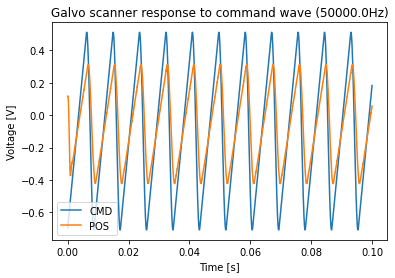

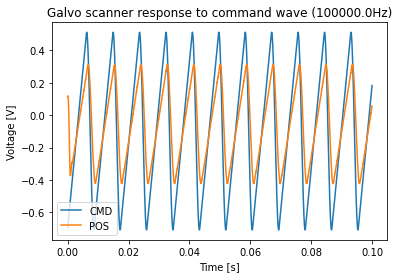

In [71]:
# Plots from 5e4 to 2.5e5 sampling rate

plot_line(t2, cmd2, freq=5e4, ylabel1="CMD", ylabel2="POS", y2=pos2)
plot_line(t, cmd, freq=1e5, ylabel1="CMD", ylabel2="POS", y2=pos)
# plot_line(t3, cmd3, freq=1.25e5, ylabel1="CMD", ylabel2="POS", y2=pos3)
# plot_line(t4, cmd4, freq=2e5, ylabel1="CMD", ylabel2="POS", y2=pos4)
# plot_line(t5, cmd5, freq=2.5e5, ylabel1="CMD", ylabel2="POS", y2=pos5)

In [86]:
# EDIT and COMMENT
def calc_time_delay_slope(f, t, cmd, pos, graph, average):
    # span of one linear scan
    start_idx = 420
    end_idx = 784
    
    cmd_slope_list = [] # list of slopes for each line in CMD waveform
    pos_slope_list = [] # list of slopes for each line in POS waveform
    slope_ratio_list = [] # ratio between slopes
    time_delay_list = [] # each entry is a list of line delays at every sample for each line
    time_ave_delay_list = [] # average of line delays for each line
    time_range_delay_list = [] # ranges of line delays for each line
    cmd_period_list = [] # cmd values for each line
    adj_pos_period_list = [] # pos values for each line
    
    for i in range(11): # checking every 434 (one whole x waveform) samples out of 5000 
        
        if start_idx <= len(cmd) and end_idx <= len(cmd):
            cmd_period = list(cmd[start_idx:end_idx])
            pos_period = list(pos[start_idx:end_idx])
            time_period = t[start_idx:end_idx]

            # get slope for one period
            cmd_max = np.nanmax(cmd_period)
            pos_max = np.nanmax(pos_period)
            cmd_min = np.nanmin(cmd_period)
            pos_min = np.nanmin(pos_period)

            cmd_max_t = cmd_period.index(float(cmd_max))
            pos_max_t = pos_period.index(float(pos_max))
            cmd_min_t = cmd_period.index(float(cmd_min))
            pos_min_t = pos_period.index(float(pos_min))

            cmd_slope = (cmd_max - cmd_min) / (time_period[cmd_max_t] - time_period[cmd_min_t])
            pos_slope = (pos_max - pos_min) / (time_period[pos_max_t] - time_period[pos_min_t])
            slope_ratio = cmd_slope / pos_slope
            
            # adjust line to according slope
            adj_pos_waveform = []
            for j in pos_period:
                adj_pos_waveform.append(j * slope_ratio)
            
            time_delay = []
            for idx in range(len(adj_pos_waveform)):
                voltage = cmd_period[idx]
                for k in range(100): # look forward to around one full period
                    if k + idx >= len(adj_pos_waveform):
                        break
                    if adj_pos_waveform[k + idx - 1] < voltage and adj_pos_waveform[k + idx] >= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                    elif adj_pos_waveform[k + idx - 1] > voltage and adj_pos_waveform[k + idx] <= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                        
            cmd_slope_list.append(cmd_slope)
            pos_slope_list.append(pos_slope)
            slope_ratio_list.append(slope_ratio)
            time_delay_list.append(time_delay)
            time_ave_delay_list.append(np.average(time_delay))
            time_range_delay_list.append(np.max(time_delay) - np.min(time_delay))
            cmd_period_list.append(cmd_period)
            adj_pos_period_list.append(adj_pos_waveform)
            
            start_idx = 434 + start_idx
            end_idx = 434 + end_idx
            
        else:
            break 
    
    if graph == "y":
        plot_xy_scatter("Slope vs. Average Time Delay (" + str(f) + " Rate)", "Slope", "Time Delay", pos_slope_list, time_ave_delay_list)
    if average == 'y':
        return pos_slope_list, time_ave_delay_list, time_range_delay_list
    else:
        return cmd_slope_list, pos_slope_list, slope_ratio_list, np.average(slope_ratio_list)

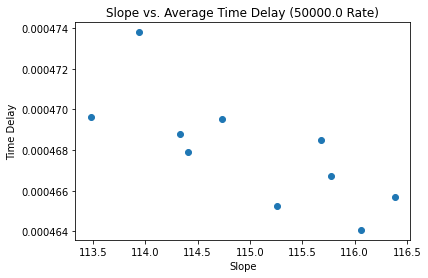

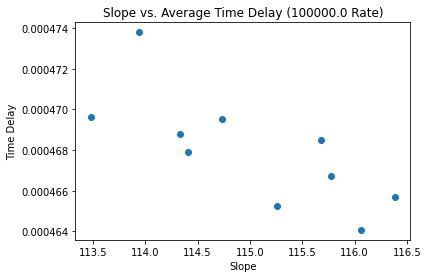

In [87]:
pos_slope_5e4, ave_delay_5e4, range_delay_5e4 = calc_time_delay_slope(5e4, t2, cmd2, pos2, "y", "y")
pos_slope_1e5, ave_delay_1e5, range_delay_1e5 = calc_time_delay_slope(1e5, t, cmd, pos, "y", "y")
# pos_slope_1_25e5, ave_delay_1_25e5, range_delay_1_25e5 = calc_time_delay_slope(1.25e5, t3, cmd3, pos3, "y", "y")
# pos_slope_2e5, ave_delay_2e5, range_delay_2e5 = calc_time_delay_slope(2e5, t4, cmd4, pos4, "y", "y")
# pos_slope_2_5e5, ave_delay_2_5e5, range_delay_2_5e5 = calc_time_delay_slope(2.5e5, t5, cmd5, pos5, "y", "y")

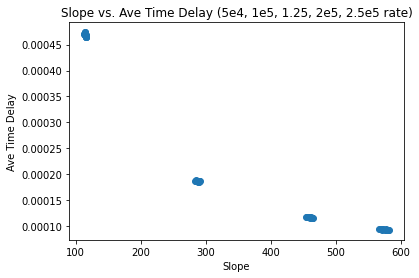

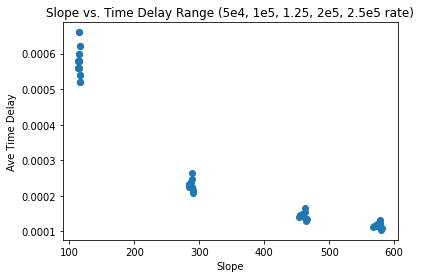

In [88]:
combined_time_delay_ave = ave_delay_5e4 + ave_delay_1e5 + ave_delay_1_25e5 + ave_delay_2e5 + ave_delay_2_5e5
combined_pos_slope = pos_slope_5e4 + pos_slope_1e5 + pos_slope_1_25e5 + pos_slope_2e5 + pos_slope_2_5e5
combined_time_delay_range = range_delay_5e4 + range_delay_1e5 + range_delay_1_25e5 + range_delay_2e5 + range_delay_2_5e5

plot_xy_scatter("Slope vs. Ave Time Delay (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)
plot_xy_scatter("Slope vs. Time Delay Range (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_range)

In [91]:
# EDIT and COMMENT

# Calculating time delay b/w cmd and pos using adjusted pos slope - using correlation

def calc_time_delay_corr(f, t, cmd, pos, graph):
    cs, ps, sr, ave_slope_ratio = calc_time_delay_slope(f, t, cmd, pos, "n", "n")
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * ave_slope_ratio)
    
    xcorr = np.correlate(pos, cmd, "full")
    dt = np.linspace(-t[-1], t[-1], (2 * len(t)) - 1)
    t_shift = dt[xcorr.argmax()]
    
    if graph == "y":
#         print("Sample Rate: " + str(f))
#         print("Time Delay (ms): " + str(t_shift * 1000) + "\n")
        plot_cmd_pos(f, t, cmd, adj_pos_waveform)
    return t_shift, adj_pos_waveform

In [92]:
# Calculating time delay b/w cmd and pos using adjusted pos slope - using averaged slope difference

# COMMENT

def calc_time_delay_ave_slope(f, t, cmd, pos):
    cs, ps, sr, ave_slope_ratio = calc_time_delay_slope(f, t, cmd, pos, "n", "n")
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * ave_slope_ratio)
    
    time_delay = []
    for idx in range(len(cmd)):
        voltage = cmd[idx]
        for j in range(100): # look forward to around one full period
            if j + idx >= len(t):
                break
            if adj_pos_waveform[idx - 1] < voltage and adj_pos_waveform[idx] > voltage:
                continue
            if adj_pos_waveform[j + idx - 1] < voltage and adj_pos_waveform[j + idx] >= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
            elif adj_pos_waveform[j + idx - 1] > voltage and adj_pos_waveform[j + idx] <= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
    
    new_time_delay = []
    for i in time_delay:
        new_time_delay.append(i * 1000)

    plot_line(t[:len(time_delay)], cmd[:len(time_delay)], title="Galvo Response Compared with Time Delay", xlabel="Time [s]", ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=adj_pos_waveform[:len(time_delay)], y3=new_time_delay)
    plot_line(t[:len(time_delay)], time_delay, title="Time vs. Corresponding Time Delay (" + str(f) + "Hz)", xlabel="Time [s]", ylabel="Time Delay [s]")
    
    return t[:len(time_delay)], cmd[:len(time_delay)], adj_pos_waveform[:len(time_delay)], new_time_delay

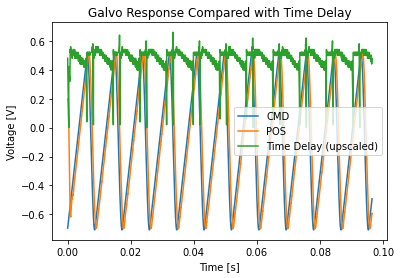

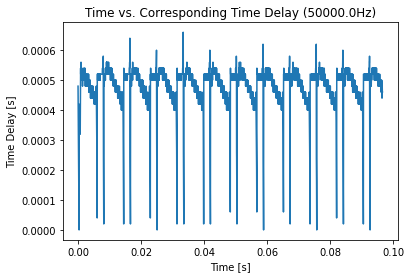

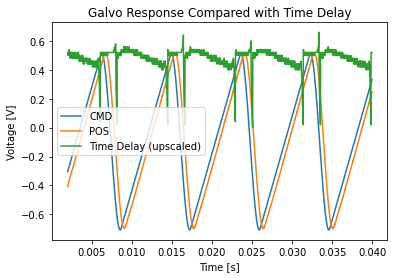

In [93]:
new_t, new_cmd, new_adj, time_delay = calc_time_delay_ave_slope(5e4, t2, cmd2, pos2)
plot_line(new_t[100:2000], new_cmd[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]", ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj[100:2000], y3=time_delay[100:2000])

In [79]:
# new_t2, new_cmd2, new_adj2, time_delay2 = calc_time_delay_ave_slope(1e5, t, cmd, pos)
# new_t3, new_cmd3, new_adj3, time_delay3 = calc_time_delay_ave_slope(1.25e5, t3, cmd3, pos3)

In [94]:
# Shifting adjusted pos waveform to see how closely matches with cmd waveform

def adj_for_delay(f, t, cmd, pos, graph):
    time_shift, adj_pos_waveform = calc_time_delay_ave_slope(f, t, cmd, pos)
    time_idx = 0
    for i in range(len(t)):
        if t[i] >= time_shift:
            time_idx = i
            break
    new_pos_waveform = adj_pos_waveform[time_idx:]
    adj_cmd_waveform = cmd[:(len(cmd) - time_idx)]
    adj_time_waveform = t[:(len(cmd) - time_idx)]
    if graph == "y":
        plot_cmd_pos(f, adj_time_waveform, adj_cmd_waveform, new_pos_waveform)

In [ ]:
# adj_for_delay(1e5, t, cmd, pos, "y")
# adj_for_delay(1e5, t[:2000], cmd[:2000], pos[:2000], "y")
# adj_for_delay(5e4, t2, cmd2, pos2, "y")
# adj_for_delay(5e4, t2[:2000], cmd2[:2000], pos2[:2000], "y")

In [ ]:
# TODO:
# combination of different slopes and zoom factors
# get different slopes but same frequencies by adjusting both sample rate and zoom (amplitude)
# try: seeing y waveform, testing different frequencies using solely sine waveforms

# DONE:
# graph: different slope vs. delay (points - hopefully linear), single scan vs delay
# make different graphs for different zoom factors (and resolution?)

In [99]:
zoom = 1.25
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame= frame[:int(frameLength / 2)]
# plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_25 = xFrame[:5000]

In [101]:
# t_z1_25, cmd_z1_25, pos_z1_25 = write_voltage_waveform(1e5, xFrame_waveform_z1_25)
t_z1_25, cmd_z1_25, pos_z1_25 = open_csv("1_25zoom")

In [106]:
zoom = 1.5
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_z1_5 = xFrame[:5000]

In [107]:
# t_z1_5, cmd_z1_5, pos_z1_5 = write_voltage_waveform(1e5, xFrame_waveform_z1_5)
t_z1_5, cmd_z1_5, pos_z1_5 = open_csv("1_5zoom")

In [111]:
zoom = 1.75
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_z1_75 = xFrame[:5000]

In [112]:
# t_z1_75, cmd_z1_75, pos_z1_75 = write_voltage_waveform(1e5, xFrame_waveform_z1_75)
t_z1_75, cmd_z1_75, pos_z1_75 = open_csv("1_75zoom")

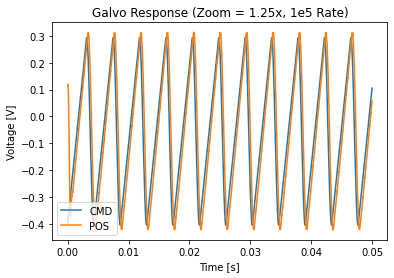

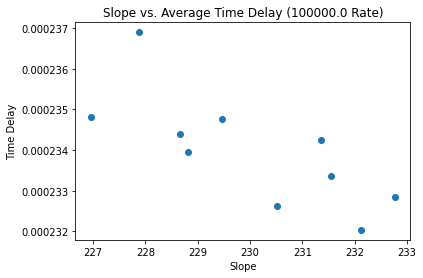

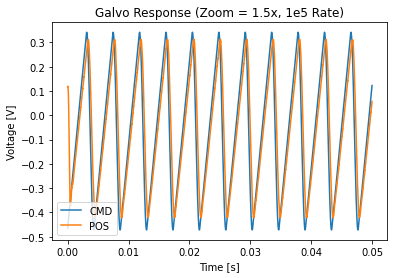

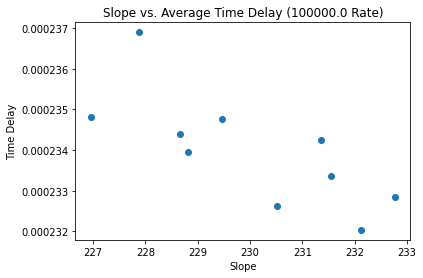

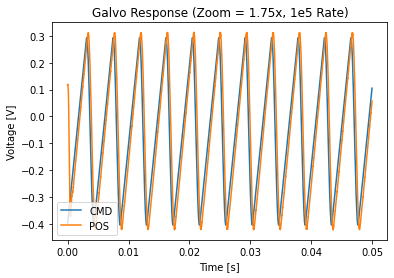

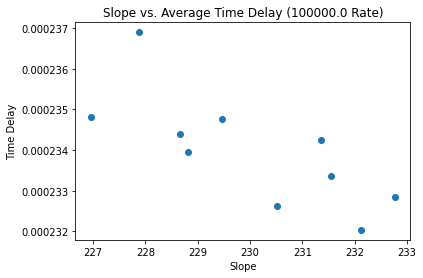

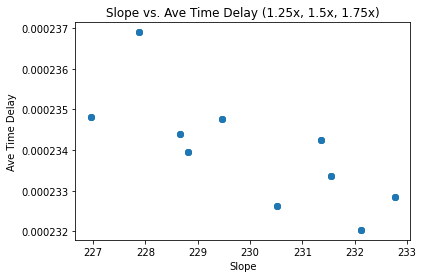

In [122]:
plot_line(t_z1_25, cmd_z1_25, title="Galvo Response (Zoom = 1.25x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_25)
pos_slope_1_25x, ave_delay_1_25x, range_delay_1_25x = calc_time_delay_slope(1e5, t_z1_25, cmd_z1_25, pos_z1_25, "y", "y")

plot_line(t_z1_5, cmd_z1_5, title="Galvo Response (Zoom = 1.5x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_5)
pos_slope_1_5x, ave_delay_1_5x, range_delay_1_5x = calc_time_delay_slope(1e5, t_z1_5, cmd_z1_5, pos_z1_5, "y", "y")

plot_line(t_z1_75, cmd_z1_75, title="Galvo Response (Zoom = 1.75x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_75)
pos_slope_1_75x, ave_delay_1_75x, range_delay_1_75x = calc_time_delay_slope(1e5, t_z1_75, cmd_z1_75, pos_z1_75, "y", "y")

combined_time_delay_ave = ave_delay_1_25x + ave_delay_1_5x + ave_delay_1_75x
combined_pos_slope = pos_slope_1_25x + pos_slope_1_5x + pos_slope_1_75x
plot_xy_scatter("Slope vs. Ave Time Delay (1.25x, 1.5x, 1.75x)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)


In [124]:
zoom = 1.66
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_z1_66 = xFrame[:5000]

In [127]:
# t_z1_66, cmd_z1_66, pos_z1_66 = write_voltage_waveform(1e5, xFrame_waveform_z1_66)
# plot_line(t_z1_66, cmd_z1_66, title="Galvo Response (Zoom = 1.66x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_66)

In [129]:
# No Undershoot - at max sampling rate for output

frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 0, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
# plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_us_0 = xFrame[:5000]

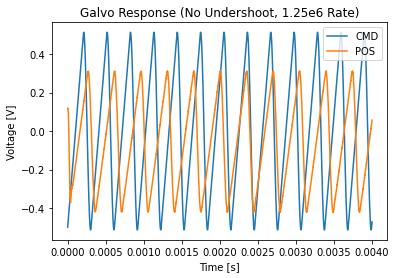

In [132]:
# t_us_0, cmd_us_0, pos_us_0 = write_voltage_waveform(1.25e6, xFrame_waveform_us_0)
t_us_0, cmd_us_0, pos_us_0 = open_csv("1_25e6rate_0us")
plot_line(t_us_0, cmd_us_0, title="Galvo Response (No Undershoot, 1.25e6 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_us_0)

In [134]:
# at lower sampling rate

# t2_5e5_us0, cmd2_5e5_us0, pos2_5e5_us0 = write_voltage_waveform(2.5e5, xFrame_waveform_us_0)
# plot_line(t2_5e5_us0, cmd2_5e5_us0, title="Galvo Response (No Undershoot, 2.5e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos2_5e5_us0)

In [135]:
# Undershoot length of 25

frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 25, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_us_25 = xFrame[:5000]

In [136]:
# t2_5e5_us25, cmd2_5e5_us25, pos2_5e5_us25 = write_voltage_waveform(2.5e5, xFrame_waveform_us_25)

In [137]:
# Undershoot Length of 75

frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 75, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_us_75 = xFrame[:5000]

In [139]:
# t2_5e5_us75, cmd2_5e5_us75, pos2_5e5_us75 = write_voltage_waveform(2.5e5, xFrame_waveform_us_75)
# plot_line(t2_5e5_us75, cmd2_5e5_us75, title="Galvo Response (75 Undershoot, 2.5e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos2_5e5_us75)

In [84]:
def new_line_regression(x_data, y_data, start, end, new_start=None, new_end=None, title="Galvo Response"):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[start:end], y_data[start:end])
    if new_start == None and new_end == None: # if length is the same
        new_start = start
        new_end = end
    
    old_y_data_section = y_data[start:end]
    new_y_data_section = y_data[new_start:new_end]
    
    # generated linear fit (same length)
    same_linear_fit = []
    for i in x_data[start:end]:
        val = intercept + slope * i
        same_linear_fit.append(val)

    # calculate voltage differences b/w actual and linear fit (same length)
    same_y_diff_list = []
    for i in range(len(same_linear_fit)):
        y_diff = abs(old_y_data_section[i] - same_linear_fit[i])
        same_y_diff_list.append(y_diff)

    # average and max of those differences (of same length)
    y_ave = np.average(same_y_diff_list)
    y_max = np.max(same_y_diff_list)
    
    # generate linear fit (longer length)
    new_linear_fit = []
    for i in x_data[new_start:new_end]:
        val = intercept + slope * i
        new_linear_fit.append(val)
    
    # calculate voltage differences b/w actual and linear fit (longer length)
    new_y_diff_list = []
    for i in range(len(new_linear_fit)):
        new_y_diff = abs(new_y_data_section[i] - new_linear_fit[i])
        new_y_diff_list.append(new_y_diff)
                                
    # finding start and stop voltages
    # upper half of data
    max_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) + i
        if idx > len(x_data): # if index goes over
            break
        else: 
            y_diff = abs(new_y_diff_list[idx])
            if y_diff > y_max: 
                max_idx = idx
                break
    y_stop = new_y_data_section[max_idx]
    
    # lower half of data
    min_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) - i
        y_diff = abs(new_y_diff_list[idx])
        if y_diff > y_max:
            min_idx = idx
            break
    y_start = new_y_data_section[min_idx]
    
    new_x = x_data[new_start:new_end]
    new_y = y_data[new_start:new_end]
    
    print(title + "\nStart Voltage: " + str(y_start) + "\nStop Voltage: " + str(y_stop))    
    plot_line(new_x, new_y, title=title, ylabel1="Actual", ylabel2="Linear Fit", ylabel3="Voltage Difference From Linear Fit", y2=new_linear_fit, y3=new_y_diff_list, markers=[min_idx,max_idx])
        
    return x_data[new_start:new_end], y_data[new_start:new_end], new_linear_fit, y_start, y_stop

In [142]:
# # Line Regression - Rate = 2.5e5, Undershoot = 0

# x1, old_y, new_y, ystart1, yend1 = new_line_regression(t2_5e5_us0, cmd2_5e5_us0, 400, 625, new_start=350, new_end=675, title="Start and Stop on CMD (2.5e5) Undershoot = 0")
# x2, old_y2, new_y2, ystart2, yend2 = new_line_regression(t2_5e5_us0, pos2_5e5_us0, 450, 675, new_start=400, new_end=725, title="Start and Stop on POS (2.5e5) Undershoot = 0")

In [143]:
# # Line Regression - Rate = 2.5e5, Undershoot = 25

# x5, old_y5, new_y5, ystart5, yend5 = new_line_regression(t2_5e5_us25, cmd2_5e5_us25, 425, 675, new_start=375, new_end=725, title="Start and Stop on CMD (2.5e5) Undershoot = 25")
# x6, old_y6, new_y6, ystart6, yend6 = new_line_regression(t2_5e5_us25, pos2_5e5_us25, 475, 725, new_start=425, new_end=775, title="Start and Stop on POS (2.5e5) Undershoot = 25")

In [144]:
# # Line Regression - Rate = 2.5e5, Undershoot = 50

# x3, old_y3, new_y3, ystart3, yend3 = new_line_regression(t5, cmd5, 450, 725, new_start=400, new_end=775, title="Start and Stop on CMD (2.5e5) Undershoot = 50")
# x4, old_y4, new_y4, ystart4, yend4 = new_line_regression(t5, pos5, 500, 775, new_start=450, new_end=825, title="Start and Stop on POS (2.5e5) Undershoot = 50")

In [145]:
# # Line Regression - Rate = 2.5e5, Undershoot = 75

# x7, old_y7, new_y7, ystart7, yend7 = new_line_regression(t2_5e5_us75, cmd2_5e5_us75, 475, 775, new_start=425, new_end=825, title="Start and Stop on CMD (2.5e5) Undershoot = 75")
# x8, old_y8, new_y8, ystart8, yend8 = new_line_regression(t2_5e5_us75, pos2_5e5_us75, 525, 800, new_start=475, new_end=875, title="Start and Stop on POS (2.5e5) Undershoot = 75")

In [148]:
# Differences b/w start/end voltages b/w CMD and position

# cmd_diff_0 = ystart1 - ystart2
# cmd_diff_25 = ystart5 - ystart6
# cmd_diff_50 = ystart3 - ystart4
# cmd_diff_75 = ystart7 - ystart8

# print("START Voltage: ")
# print("CMD/POS Difference for 0 undershoot: " + str(cmd_diff_0))
# print("CMD/POS Difference for 25 undershoot: " + str(cmd_diff_25))
# print("CMD/POS Difference for 50 undershoot: " + str(cmd_diff_50))
# print("CMD/POS Difference for 75 undershoot: " + str(cmd_diff_75))

# cmd_diff_0 = yend1 - yend2
# cmd_diff_25 = yend5 - yend6
# cmd_diff_50 = yend3 - yend4
# cmd_diff_75 = yend7 - yend8

# print("\nEND Voltage: ")
# print("CMD/POS Difference for 0 undershoot: " + str(cmd_diff_0))
# print("CMD/POS Difference for 25 undershoot: " + str(cmd_diff_25))
# print("CMD/POS Difference for 50 undershoot: " + str(cmd_diff_50))
# print("CMD/POS Difference for 75 undershoot: " + str(cmd_diff_75))

In [67]:
# One x scan waveform
def scan_waveform(start_voltage, end_voltage, time_frame, sample_rate):
    # initial prameters (const)
    # end voltage 1 for now
    # time_frame = .002 # in seconds
    
    # calculate
    # line_delay
    # maybe overshoot if applicable
    
    rv_slope = -2 * 1000/ (sample_rate)  # 2-5 V/ms converted to V/samples - EDIT
    slope_ratio = 1.4 * (4.35e-7 * sample_rate + 1.59413) # to adjust for output waveform
    
    # waveform parameters
    fw_samps = int(time_frame * sample_rate) # samples in scan line
    fw_slope = ( (end_voltage - start_voltage) * slope_ratio ) / fw_samps # slope of scan line (V/samples)
    
    # Generating Scanner Waveform
    scan_line = []
    retrace = []
    
    scan_start = 0 # start at 0 volts
    time_undershoot = .0005 # 5 ms
    us_samps = sample_rate * time_undershoot # samples in undershoot
    us_start = scan_start - us_samps * fw_slope # voltage where undershoot starts
    
    for i in range(fw_samps):
        val = i * fw_slope + us_start
        scan_line.append(val)
    
    rv_samps = int(-1 * (end_voltage - start_voltage) * slope_ratio / rv_slope) # samples in retrace
    for j in range(rv_samps):
        retrace.append(j * rv_slope + val)
    
    complete_waveform = scan_line + retrace # list of voltages
    num_samples = fw_samps + rv_samps
    samples = []
    for k in range(num_samples):
        samples.append(k)

    return complete_waveform, samples

# complete x scan waveform
def x_waveform(waveform, samples, resolution):
    complete_waveform = []
    for i in range(resolution):
        for j in samples:
            complete_waveform.append(waveform[j])
    return complete_waveform

In [68]:
galvo_waveform_5e4, num_samples_5e4 = scan_waveform(0, 1, .002, sample_rate=5e4) # 0 - 1V at 5e4
galvo_waveform_2_5e5, num_samples_2_5e5 = scan_waveform(0, 1, .002, sample_rate=2.5e5) # 0 - 1V at 2.5e5
galvo_waveform_1_25e6, num_samples_1_25e6 = scan_waveform(0, 1, .002, sample_rate=1.25e6) # 0 - 1V at 1.25e6

galvo_waveform_2e5_05, num_samples_2e5_05 = scan_waveform(0, 0.5, .002, sample_rate=2e5) # 0 - 0.5V at 2e5
galvo_waveform_2_5e5_05, num_samples_2_5e5_05 = scan_waveform(0, 0.5, .002, sample_rate=2.5e5) # 0 - 0.5V at 2.5e5

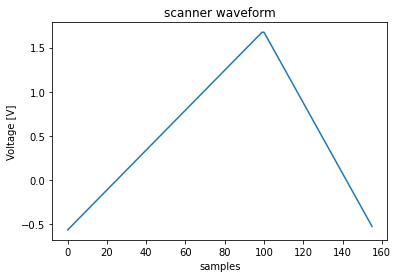

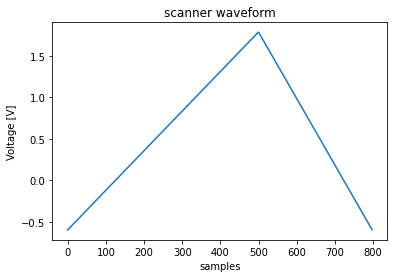

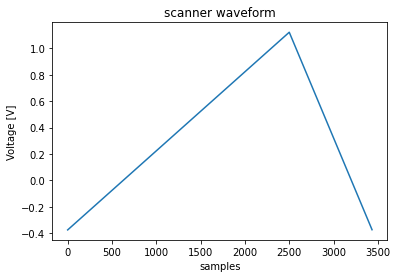

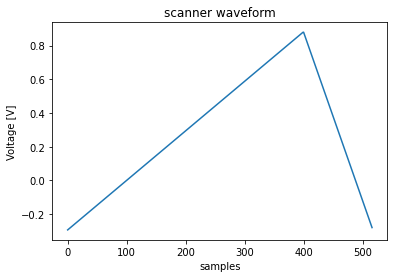

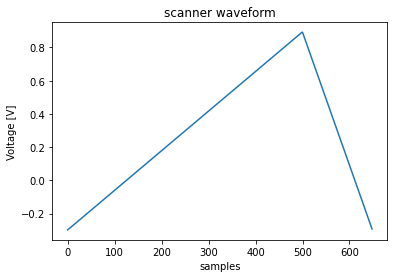

In [94]:
plot_line(num_samples_5e4, galvo_waveform_5e4, title="scanner waveform", xlabel="samples")
plot_line(num_samples_2_5e5, galvo_waveform_2_5e5, title="scanner waveform", xlabel="samples")
plot_line(num_samples_1_25e6, galvo_waveform_1_25e6, title="scanner waveform", xlabel="samples")

plot_line(num_samples_2e5_05, galvo_waveform_2e5_05, title="scanner waveform", xlabel="samples")
plot_line(num_samples_2_5e5_05, galvo_waveform_2_5e5_05, title="scanner waveform", xlabel="samples")

In [70]:
waveform_5e4 = x_waveform(galvo_waveform_5e4, num_samples_5e4, 256)
waveform_2_5e5 = x_waveform(galvo_waveform_2_5e5, num_samples_2_5e5, 256)
waveform_1_25e6 = x_waveform(galvo_waveform_1_25e6, num_samples_1_25e6, 256)

waveform_2e5_05 = x_waveform(galvo_waveform_2e5_05, num_samples_2e5_05, 256)
waveform_2_5e5_05 = x_waveform(galvo_waveform_2_5e5_05, num_samples_2_5e5_05, 256)

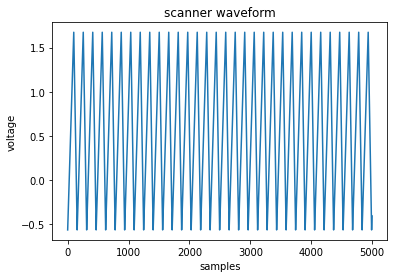

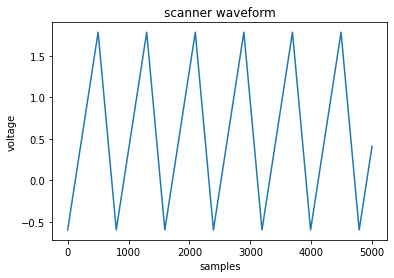

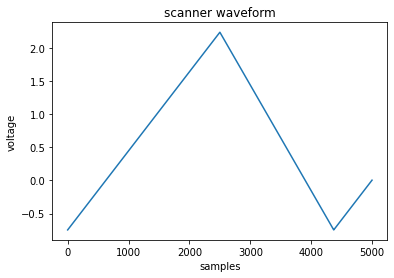

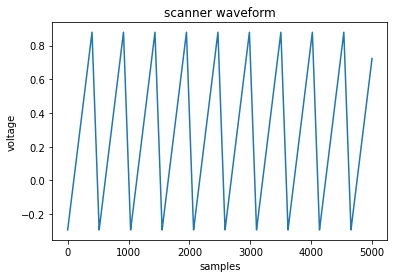

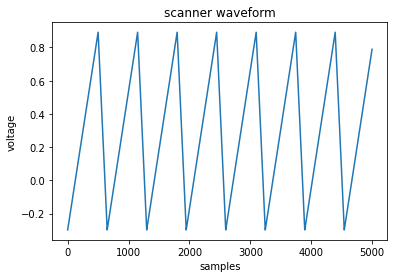

In [71]:
plot_galvo("scanner waveform", "samples", "voltage", waveform_5e4[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e6[:5000])

plot_galvo("scanner waveform", "samples", "voltage", waveform_2e5_05[:5000])
plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5_05[:5000])

3435


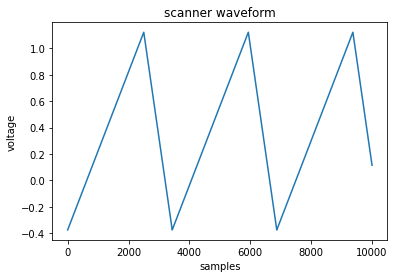

In [72]:
galvo_waveform_1_25e6, num_samples_1_25e6 = scan_waveform(0, 0.5, .002, sample_rate=1.25e6)
waveform_1_25e6 = x_waveform(galvo_waveform_1_25e6, num_samples_1_25e6, 256)
plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e6[:10000])
print(len(num_samples_1_25e6))

In [89]:
xframe_waveform = waveform_2_5e5[:5000]
xframe_waveform_05 = waveform_2_5e5_05[:5000]
xframe_waveform_2e5_05 = waveform_2e5_05[:5000]

In [74]:
t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05 = write_voltage_waveform(2.5e5, xframe_waveform_05)

Start and Stop on CMD (2.5e5)
Start Voltage: -0.29237203199999984
Stop Voltage: 0.8916279680000001
Start and Stop on POS (2.5e5)
Start Voltage: -0.1316333680373928
Stop Voltage: 0.5100110720108914


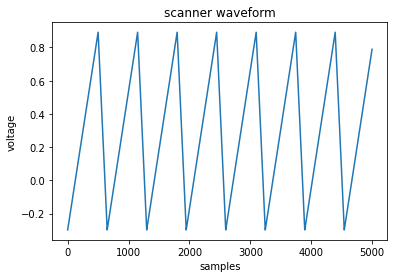

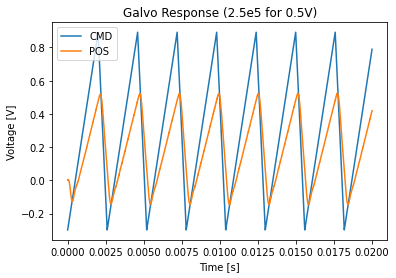

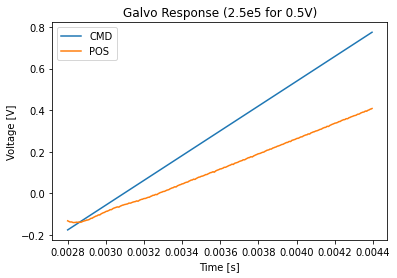

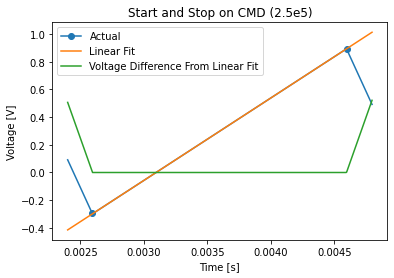

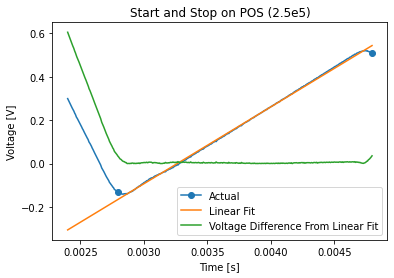

In [135]:
# 0 - 0.5V at 2.5e5 rate

plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5_05[:5000])
plot_line(t_2_5e5_05, cmd_2_5e5_05, freq=2.5e5, title="Galvo Response (2.5e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_05)
plot_line(t_2_5e5_05[700:1100], cmd_2_5e5_05[700:1100], freq=2.5e5, title="Galvo Response (2.5e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_05[700:1100])
x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_05, cmd_2_5e5_05, 700, 1100, new_start=600, new_end=1200, title="Start and Stop on CMD (2.5e5)")
x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_05, pos_2_5e5_05, 700, 1100, new_start=600, new_end=1200, title="Start and Stop on POS (2.5e5)")

In [90]:
t_2e5_05, cmd_2e5_05, pos_2e5_05 = write_voltage_waveform(2e5, xframe_waveform_2e5_05)

Start and Stop on CMD (2e5)
Start Voltage: -0.28034872749999984
Stop Voltage: 0.8796512725000001
Start and Stop on POS (2e5)
Start Voltage: -0.1388217835922969
Stop Voltage: 0.5148554424110876


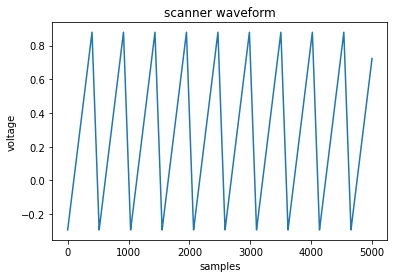

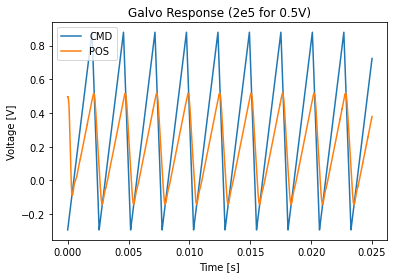

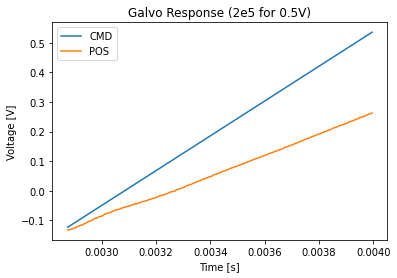

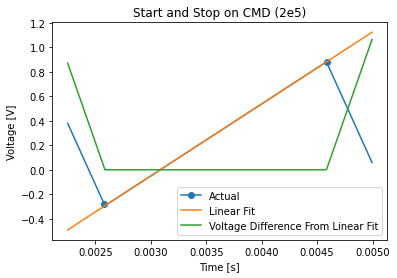

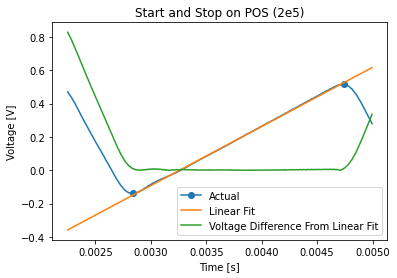

In [138]:
# 0 - 0.5V at 2e5 rate

plot_galvo("scanner waveform", "samples", "voltage", waveform_2e5_05[:5000])
plot_line(t_2e5_05, cmd_2e5_05, title="Galvo Response (2e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2e5_05)
plot_line(t_2e5_05[575:800], cmd_2e5_05[575:800], title="Galvo Response (2e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_2e5_05[575:800])
x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = new_line_regression(t_2e5_05, cmd_2e5_05, 575, 800, new_start=450, new_end=1000, title="Start and Stop on CMD (2e5)")
x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = new_line_regression(t_2e5_05, pos_2e5_05, 600, 850, new_start=450, new_end=1000, title="Start and Stop on POS (2e5)")

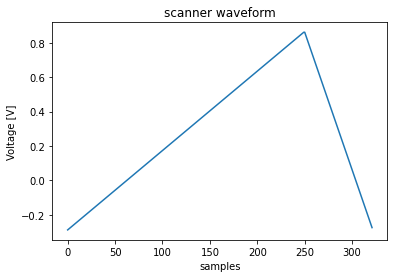

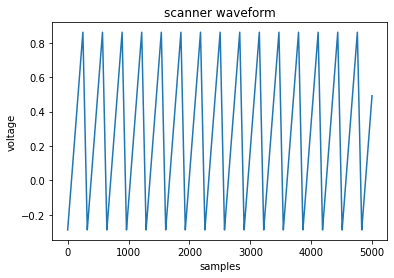

In [139]:
# 0 - 0.5V at 1.25e5 rate

galvo_waveform_1_25e5_05, num_samples_1_25e5_05 = scan_waveform(0, 0.5, .002, sample_rate=1.25e5) # 0 - 0.5V at 5e4
plot_line(num_samples_1_25e5_05, galvo_waveform_1_25e5_05, title="scanner waveform", xlabel="samples")
waveform_1_25e5_05 = x_waveform(galvo_waveform_1_25e5_05, num_samples_1_25e5_05, 256)
plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e5_05[:5000])
xframe_waveform_1_25e5_05 = waveform_1_25e5_05[:5000]

In [110]:
t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05 = write_voltage_waveform(1.25e5, xframe_waveform_1_25e5_05)

Start and Stop on CMD (1.25e5)
Start Voltage: -0.27515068900000017
Stop Voltage: 0.860849311
Start and Stop on POS (1.25e5)
Start Voltage: -0.05818651058024166
Stop Voltage: 0.5053229716504779


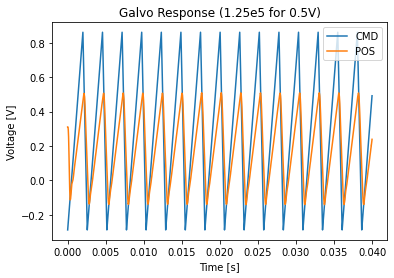

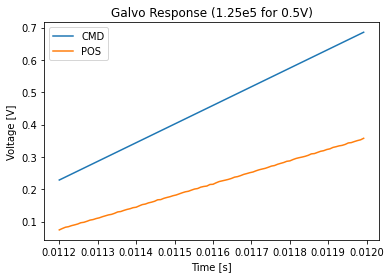

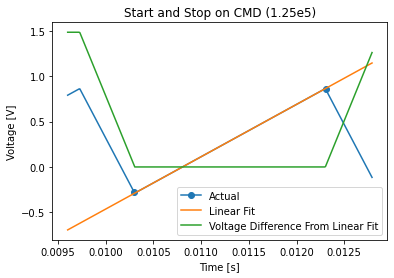

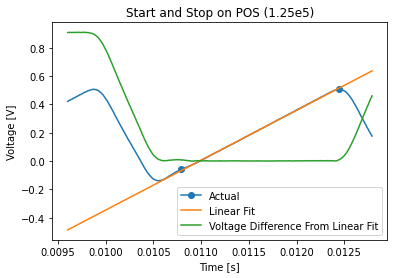

In [141]:
# 0 - 0.5V at 1.25e5

plot_line(t_1_25e5_05, cmd_1_25e5_05, title="Galvo Response (1.25e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_1_25e5_05)
plot_line(t_1_25e5_05[1400:1500], cmd_1_25e5_05[1400:1500], title="Galvo Response (1.25e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_1_25e5_05[1400:1500])
x_1_25e5_05, old_y_1_25e5_05, new_y_1_25e5_05, ystart_1_25e5_05, yend_1_25e5_05 = new_line_regression(t_1_25e5_05, cmd_1_25e5_05, 1400, 1500, new_start=1200, new_end=1600, title="Start and Stop on CMD (1.25e5)")
x_1_25e5_05, old_y_1_25e5_05, new_y_1_25e5_05, ystart_1_25e5_05, yend_1_25e5_05 = new_line_regression(t_1_25e5_05, pos_1_25e5_05, 1350, 1500, new_start=1200, new_end=1600, title="Start and Stop on POS (1.25e5)")

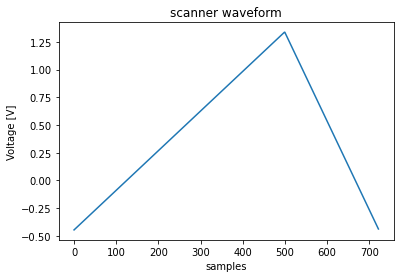

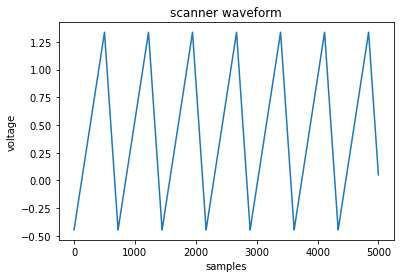

In [142]:
# 0 - 0.75V at 2.5e5 rate

galvo_waveform_2_5e5_075, num_samples_2_5e5_075 = scan_waveform(0, 0.75, .002, sample_rate=2.5e5) # 0 - 0.5V at 5e4
plot_line(num_samples_2_5e5_075, galvo_waveform_2_5e5_075, title="scanner waveform", xlabel="samples")
waveform_2_5e5_075 = x_waveform(galvo_waveform_2_5e5_075, num_samples_2_5e5_075, 256)
plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5_075[:5000])
xframe_waveform_2_5e5_075 = waveform_2_5e5_075[:5000]

In [143]:
t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075 = write_voltage_waveform(2.5e5, xframe_waveform_2_5e5_075)

Start and Stop on CMD (2.5e5)
Start Voltage: -0.438558048
Stop Voltage: 1.337441952
Start and Stop on POS (2.5e5)
Start Voltage: -0.2183631611270632
Stop Voltage: 0.7869215815142203


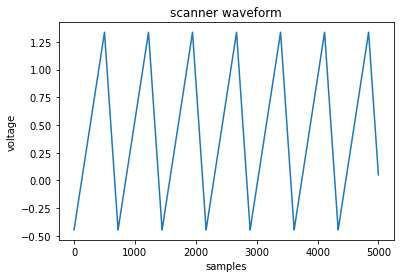

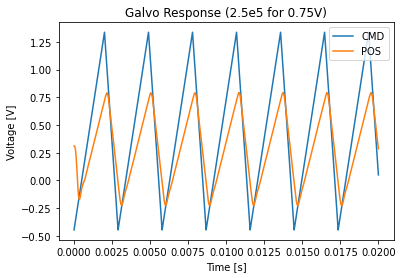

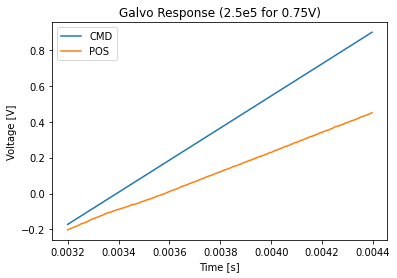

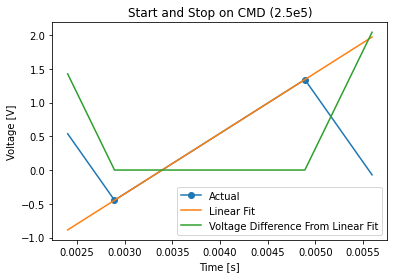

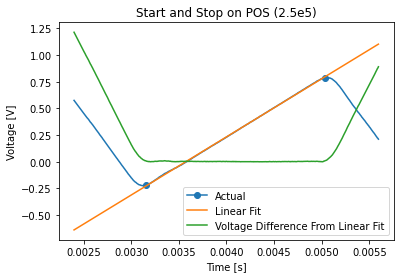

In [149]:
# 0 - 0.75V at 2.5e5 rate

plot_galvo("scanner waveform", "samples", "voltage", waveform_2_5e5_075[:5000])
plot_line(t_2_5e5_075, cmd_2_5e5_075, freq=2.5e5, title="Galvo Response (2.5e5 for 0.75V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_075)
plot_line(t_2_5e5_075[800:1100], cmd_2_5e5_075[800:1100], freq=2.5e5, title="Galvo Response (2.5e5 for 0.75V)", ylabel1="CMD", ylabel2="POS", y2=pos_2_5e5_075[800:1100])
x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_075, cmd_2_5e5_075, 800, 1200, new_start=600, new_end=1400, title="Start and Stop on CMD (2.5e5)")
x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_075, pos_2_5e5_075, 800, 1200, new_start=600, new_end=1400, title="Start and Stop on POS (2.5e5)")

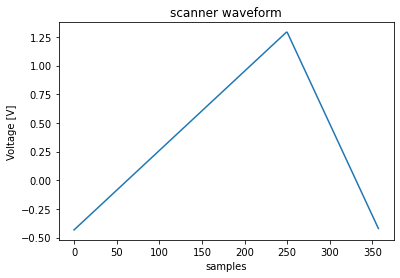

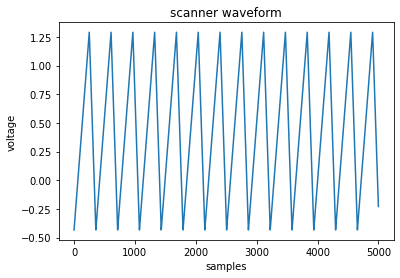

In [150]:
# 0 - 0.75V at 1.25e5 rate

galvo_waveform_1_25e5_075, num_samples_1_25e5_075 = scan_waveform(0, 0.75, .002, sample_rate=1.25e5) # 0 - 0.5V at 5e4
plot_line(num_samples_1_25e5_075, galvo_waveform_1_25e5_075, title="scanner waveform", xlabel="samples")
waveform_1_25e5_075 = x_waveform(galvo_waveform_1_25e5_075, num_samples_1_25e5_075, 256)
plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e5_075[:5000])
xframe_waveform_1_25e5_075 = waveform_1_25e5_075[:5000]

In [151]:
t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075 = write_voltage_waveform(1.25e5, xframe_waveform_1_25e5_075)

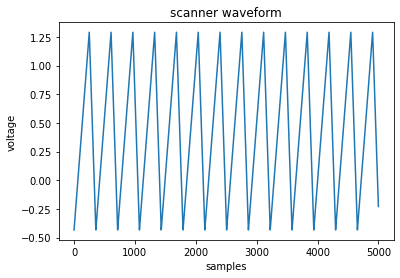

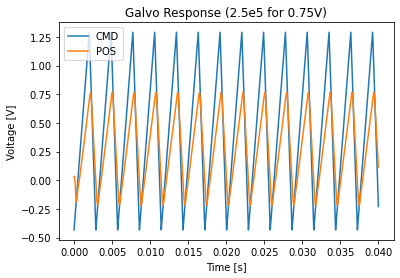

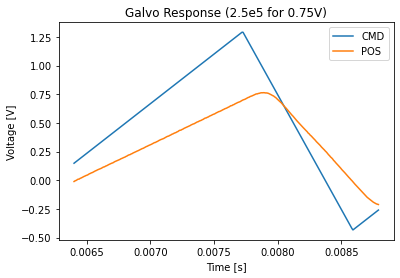

In [152]:
# 0 - 0.75V at 1.25e5 rate

plot_galvo("scanner waveform", "samples", "voltage", waveform_1_25e5_075[:5000])
plot_line(t_1_25e5_075, cmd_1_25e5_075, freq=2.5e5, title="Galvo Response (2.5e5 for 0.75V)", ylabel1="CMD", ylabel2="POS", y2=pos_1_25e5_075)
plot_line(t_1_25e5_075[800:1100], cmd_1_25e5_075[800:1100], freq=2.5e5, title="Galvo Response (2.5e5 for 0.75V)", ylabel1="CMD", ylabel2="POS", y2=pos_1_25e5_075[800:1100])
# x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_075, cmd_2_5e5_075, 800, 1200, new_start=600, new_end=1400, title="Start and Stop on CMD (2.5e5)")
# x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = new_line_regression(t_2_5e5_075, pos_2_5e5_075, 800, 1200, new_start=600, new_end=1400, title="Start and Stop on POS (2.5e5)")

In [154]:
write_to_csv2("2_5e5rateto0_5v", t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05)

In [155]:
write_to_csv2("2e5rateto0_5v", t_2e5_05, cmd_2e5_05, pos_2e5_05)

In [156]:
write_to_csv2("1_25e5rateto0_5v", t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05)

In [157]:
write_to_csv2("2_5e5rateto0_75v", t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075)

In [158]:
write_to_csv2("1_25e5rateto0_75v", t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075)